In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline
from tslearn.clustering import silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import time
from sklearn.manifold import TSNE, MDS

c:\Users\ntxuy\Desktop\TimeSeriesAnalysis\time_series_venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

In [ ]:

from datetime import datetime


import matplotlib.ticker as ticker
plt.style.use('seaborn-v0_8-darkgrid')
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler


import sklearn
from sklearn.cluster import KMeans
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

In [4]:
df = pd.read_csv('walmart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [9]:
df.head()

df.Date = pd.to_datetime(df.Date, format="%d-%m-%Y")

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
# agrregate sales by stores
store_sales = df.groupby(['Date', 'Store'], as_index=False).aggregate({'Weekly_Sales': 'sum'})
store_sales.sample(10)

,Date,Store,Weekly_Sales
4654,2012-01-27,20,1761016.51
4849,2012-02-24,35,805028.74
1741,2010-10-29,32,1115138.51
300,2010-03-19,31,1332261.01
2782,2011-04-08,38,392152.30
3529,2011-08-05,20,2189353.63
5134,2012-04-13,5,351832.03
4295,2011-12-02,21,793184.25
4916,2012-03-09,12,1113208.57
2789,2011-04-08,45,750182.71


In [9]:
# Feature matrix with shape (45 stores x time_observations)
series_df = store_sales.pivot(index='Store', columns='Date') 
series_df = series_df.dropna(axis='columns')
series_df.head()

Weekly_Sales                                                  \
Date    2010-02-05  2010-02-12  2010-02-19  2010-02-26  2010-03-05   
Store                                                                
1       1643690.90  1641957.44  1611968.17  1409727.59  1554806.68   
2       2136989.46  2137809.50  2124451.54  1865097.27  1991013.13   
3        461622.22   420728.96   421642.19   407204.86   415202.04   
4       2135143.87  2188307.39  2049860.26  1925728.84  1971057.44   
5        317173.10   311825.70   303447.57   270281.63   288855.71   

                                                                   ...  \
Date   2010-03-12  2010-03-19  2010-03-26  2010-04-02  2010-04-09  ...   
Store                                                              ...   
1      1439541.59  1472515.79  1404429.92  1594968.28  1545418.53  ...   
2      1990483.78  1946070.88  1750197.81  2066187.72  1954689.21  ...   
3       384200.69   375328.59   359949.27   423294.40   415870.28  ...   
4      1894324.09  1897429.36  1762539.30  1979247.12  1818452.72  ...   
5       297293.59   281706.41   273282.97   331406.00   328020.49  ...   

                                                                               \
Date   2012-08-24  2012-08-31  2012-09-07  2012-09-14  2012-09-21  2012-09-28   
Store                                                                           
1      1494122.38  1582083.40  1661767.33  1517428.87  1506126.06  1437059.26   
2      1876788.15  1947083.30  1898777.07  1814806.63  1829415.67  1746470.56   
3       412449.67   408838.73   408229.73   407589.16   414392.09   389813.02   
4      2125241.68  2081181.35  2125104.72  2117854.60  2119438.53  2027620.23   
5       320831.36   344642.01   350648.91   299800.67   307306.76   310141.68   

                                                       
Date   2012-10-05  2012-10-12  2012-10-19  2012-10-26  
Store                                                  
1      1670785.97  1573072.81  1508068.77  1493659.74  
2      1998321.04  1900745.13  1847990.41  1834458.35  
3       443557.65   410804.39   424513.08   405432.70  
4      2209835.43  2133026.07  2097266.85  2149594.46  
5       343048.29   325345.41   313358.15   319550.77  

[5 rows x 143 columns]

In [10]:
# Scaling
scaler = StandardScaler()

# First transposition - to have series in columns (allows scaling each series independently)
# Second Transposition - come back to initial feature matrix shape (n_stores x time_observations)
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(series_df.T).T 
scaled_ts

array([[ 0.56889909,  0.55774674,  0.36480833, ...,  0.11457187,
        -0.30363691, -0.39633857],
       [ 0.89186015,  0.89532241,  0.83892429, ..., -0.10557771,
        -0.32831134, -0.38544451],
       [ 1.27645385,  0.39050125,  0.41028638, ...,  0.17548542,
         0.47248422,  0.05910774],
       ...,
       [ 0.33875037,  1.22587521,  0.63458307, ..., -0.34494093,
        -0.23248576, -1.13013975],
       [-0.87768808, -0.64401336, -1.4099704 , ...,  1.42029205,
         0.85175156,  2.363348  ],
       [ 0.80723158, -0.99445062,  0.42619325, ..., -0.39716304,
        -0.52312483, -0.19813017]])

In [11]:
# Run KMeans and plot the results 
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    """
    Runs KMeans n times (according to max_cluster range)

    data: pd.DataFrame or np.array
        Time Series Data
    max_clusters: int
        Number of different clusters for KMeans algorithm
    metric: str
        Distance metric between the observations
    seed: int
        random seed
    Returns: 
    -------
    None      
    """
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]

CPU times: total: 9.69 s
Wall time: 29.3 s


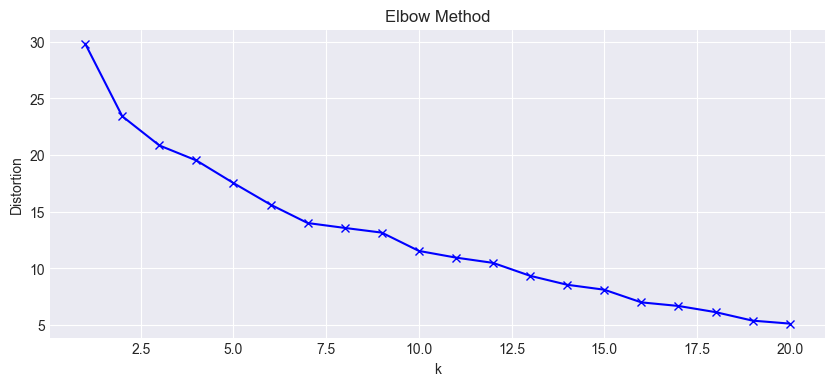

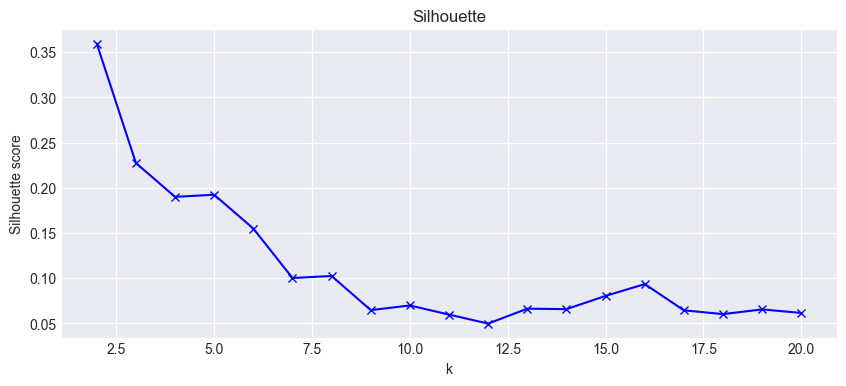

In [12]:
%%time
SEED = 23 # Maybe?
# Run the algorithm using DTW algorithm 
get_kmeans_results(data=scaled_ts, max_clusters=20, metric='dtw', seed=SEED)

In [13]:
# Visualization for obtained clusters   
def plot_clusters(data, cluster_model, dim_red_algo):
    """
    Plots clusters obtained by clustering model 

    data: pd.DataFrame or np.array
        Time Series Data
    cluster_model: Class
        Clustering algorithm 
    dim_red_algo: Class
        Dimensionality reduction algorithm (e.g. TSNE/PCA/MDS...) 
    Returns:
    -------
    None
    """
    cluster_labels = cluster_model.fit_predict(data)
    centroids = cluster_model.cluster_centers_
    u_labels = np.unique(cluster_labels)
    
    # Centroids Visualization
    plt.figure(figsize=(16, 10))
    plt.scatter(centroids[:, 0] , centroids[:, 1] , s=150, color='r', marker="x")
    
    # Downsize the data into 2D
    if data.shape[1] > 2:
        data_2d = dim_red_algo.fit_transform(data)
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)
    else:
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)

    plt.title('Clustered Data')
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.grid(True)
    plt.legend(title='Cluster Labels');

CPU times: total: 719 ms
Wall time: 537 ms


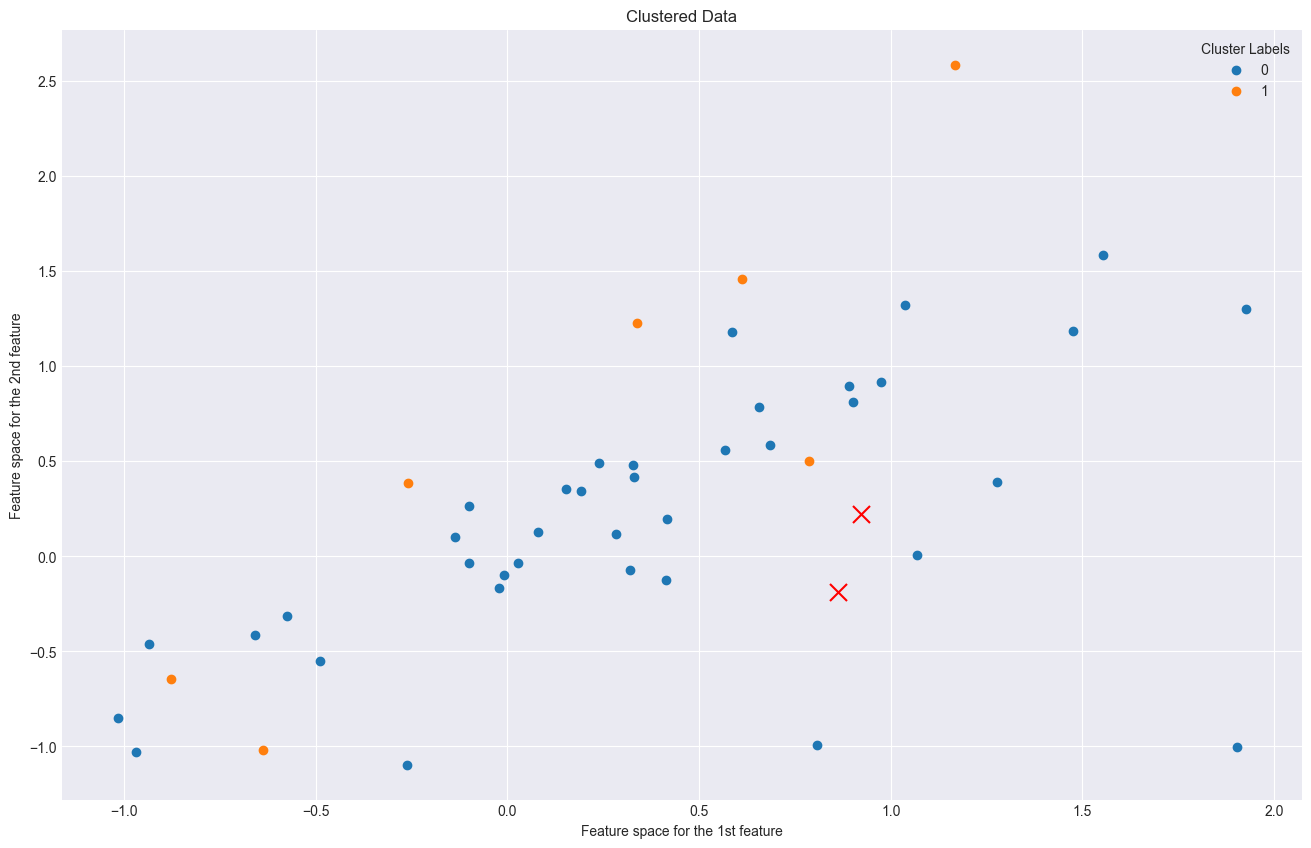

In [17]:
%%time

# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=scaled_ts,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.62it/s]


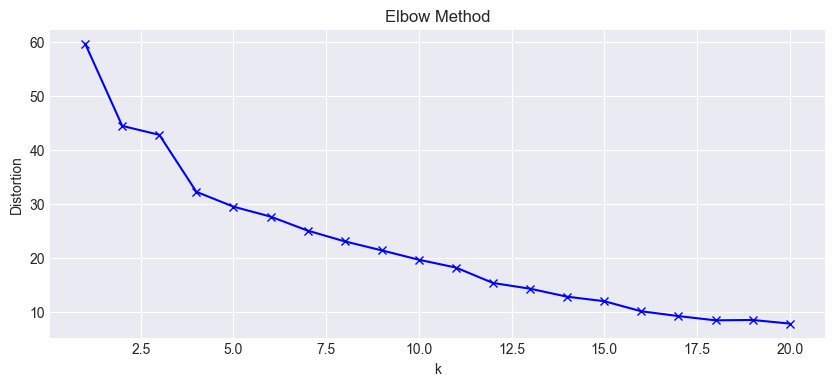

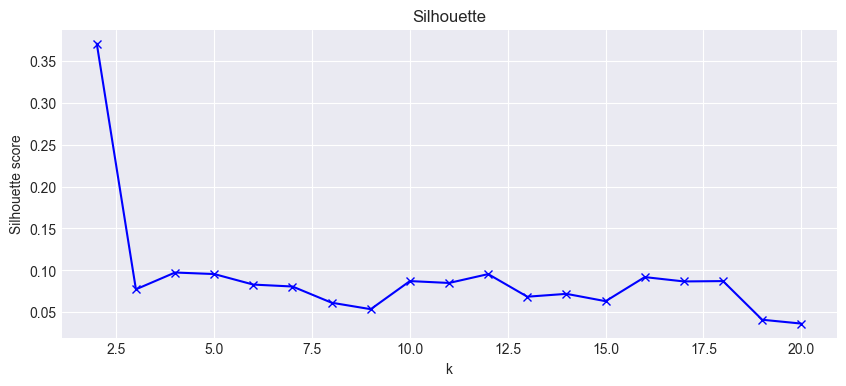

In [19]:
# Now using euclidean metric
get_kmeans_results(data=scaled_ts, max_clusters=20, metric='euclidean', seed=SEED)

## Down sizing


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27it/s]


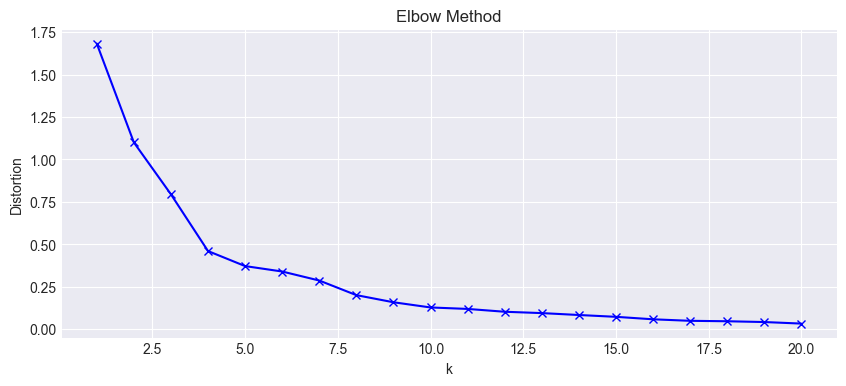

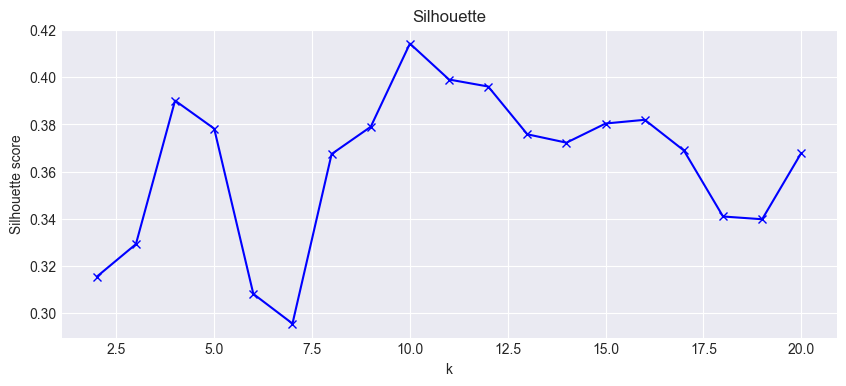

In [20]:
# Downsize the features into 2D
tsne = TSNE(n_components=2, init='pca', random_state=SEED)
data_tsne = tsne.fit_transform(scaled_ts)

get_kmeans_results(data=data_tsne, max_clusters=20, metric='dtw', seed=SEED)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.05it/s]


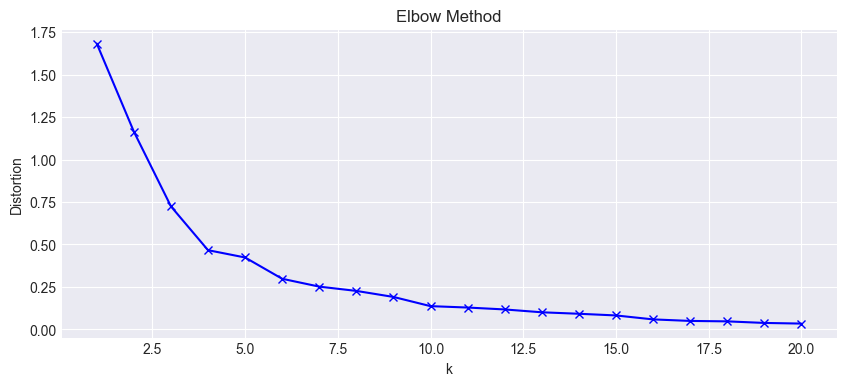

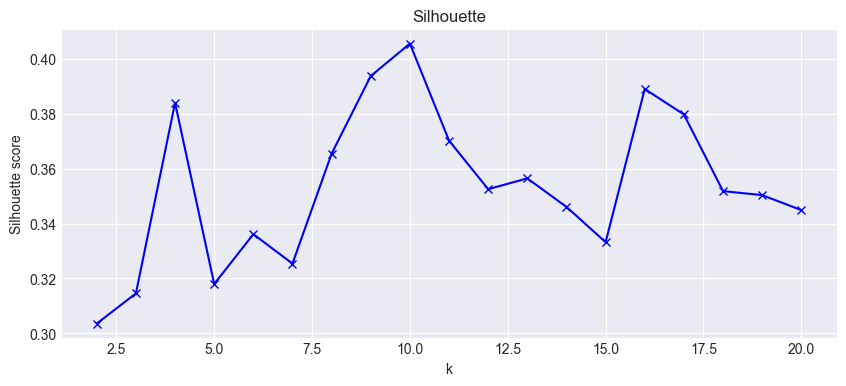

In [21]:
# Downsize the features into 2D
tsne = TSNE(n_components=2, init='pca', random_state=SEED)
data_tsne = tsne.fit_transform(scaled_ts)

get_kmeans_results(data=data_tsne, max_clusters=20, metric='euclidean', seed=SEED)

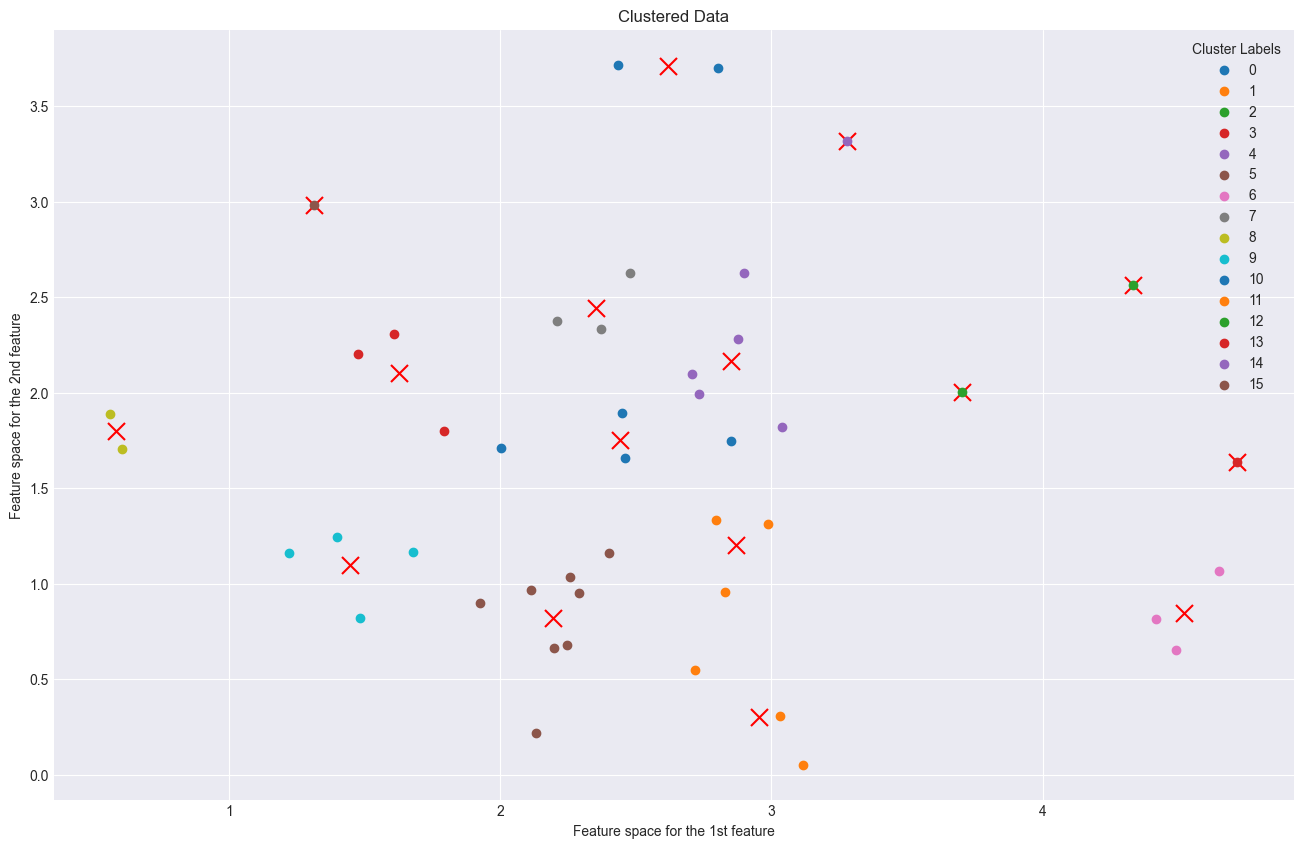

In [24]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=16, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_tsne,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

## MultiDimensional Scaling (MDS)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15it/s]


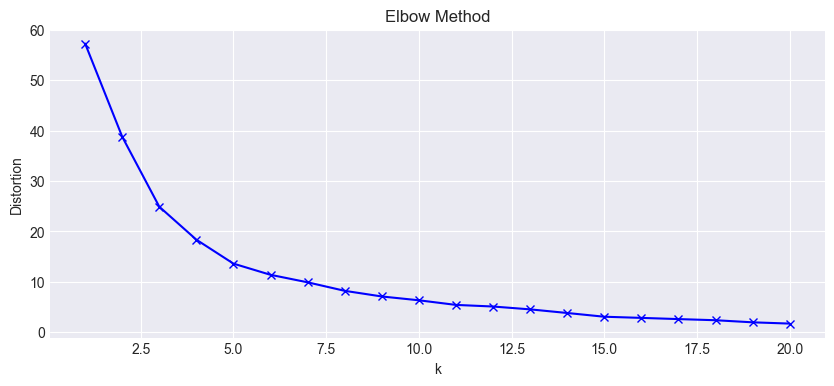

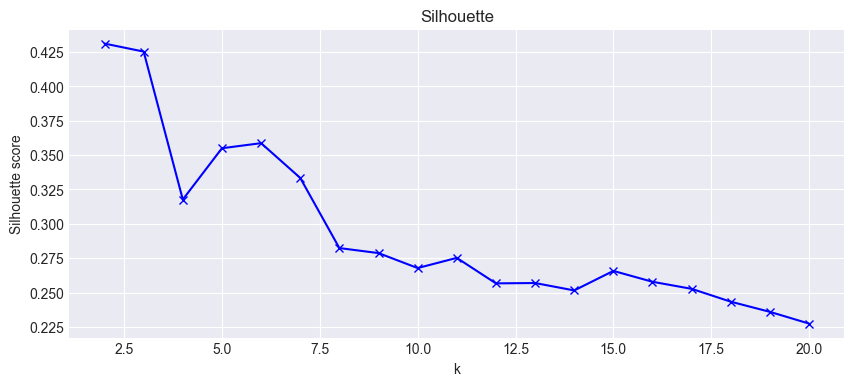

In [26]:
mds = MDS(n_components=2, n_init=3, max_iter=100, random_state=SEED)
data_mds = mds.fit_transform(scaled_ts) 

get_kmeans_results(data=data_mds, max_clusters=20, metric='dtw', seed=SEED)

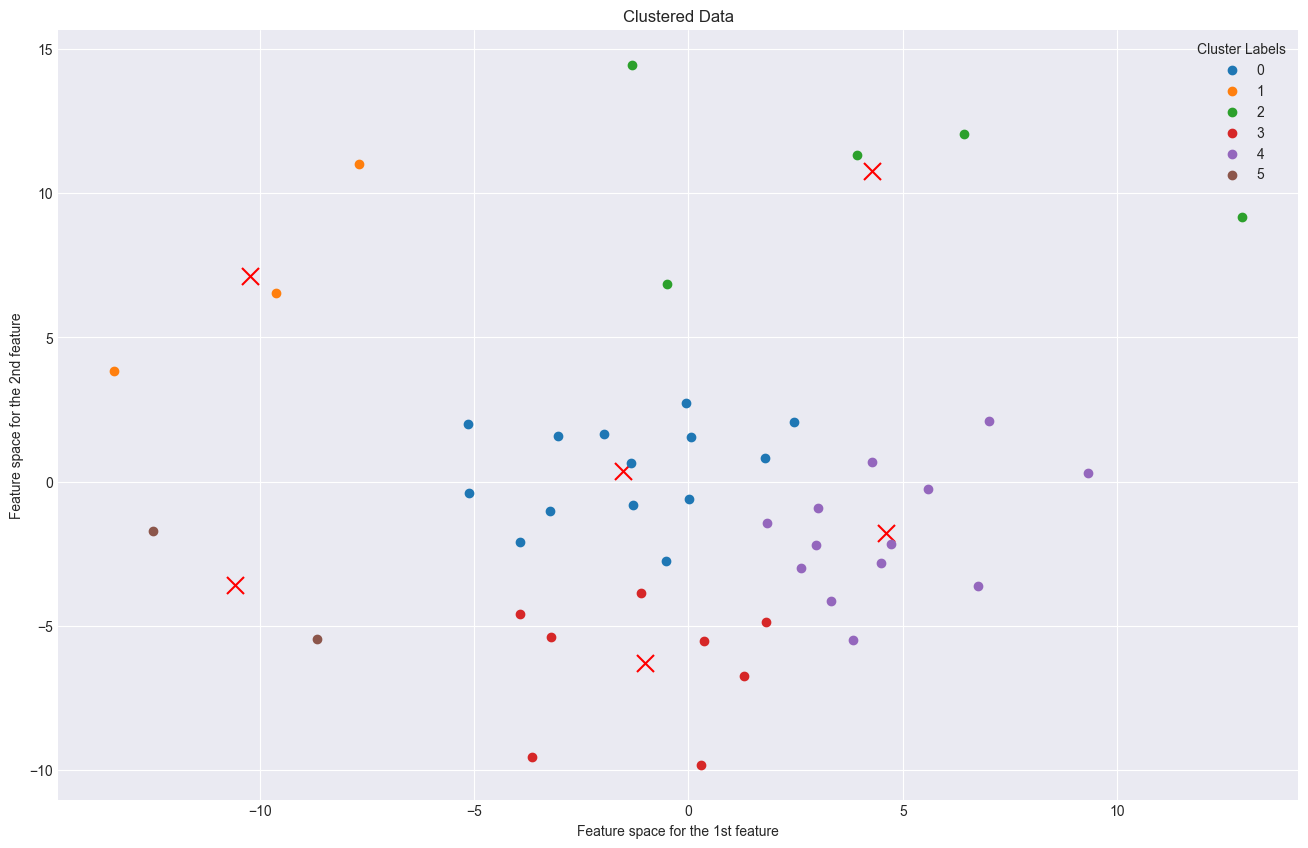

In [29]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=6, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_mds,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=10, init='pca', random_state=SEED))

## Time Series KMeans Results

In [52]:
# Train TimeSeriesKMeans with MDS
kmeans_model = TimeSeriesKMeans(n_clusters=10, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = kmeans_model.fit_predict(data_mds)

ts_clustered = [ scaled_ts[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

In [53]:
# 'cluster_labels' is the output of KMeans clustering

# Map each store to its cluster
store_cluster_mapping = pd.DataFrame({
    'Store': series_df.index,
    'Cluster': cluster_labels
})

# Print which series belong to which clusters
for cluster in sorted(store_cluster_mapping['Cluster'].unique()):
    stores_in_cluster = store_cluster_mapping[store_cluster_mapping['Cluster'] == cluster]['Store'].tolist()
    print(f"Cluster {cluster}: {stores_in_cluster}")

Cluster 0: [2, 8, 10, 11, 12, 13, 20, 31, 34, 45]
Cluster 1: [37, 38, 42]
Cluster 2: [30, 33, 43]
Cluster 3: [6, 14, 15, 18, 19, 21, 22, 27, 29, 35]
Cluster 4: [17, 44]
Cluster 5: [16, 23, 24, 25, 26, 40]
Cluster 6: [36]
Cluster 7: [1, 3, 4, 5, 9]
Cluster 8: [7, 32, 39, 41]
Cluster 9: [28]


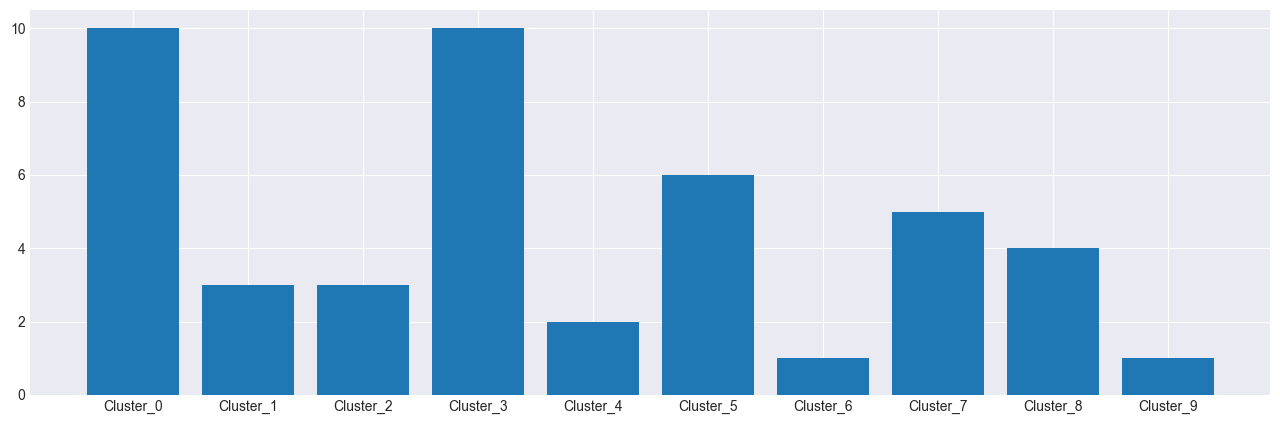

In [54]:
# distribution in the obtained clusters 
labels = [f'Cluster_{i}' for i in range(len(ts_clustered))]
samples_in_cluster = [val.shape[0] for val in ts_clustered]

plt.figure(figsize=(16,5))
plt.bar(labels, samples_in_cluster);

In [39]:
# ploting time series after being clustered

def plot_cluster_ts(current_cluster):
    """
    Plots time series in a cluster 

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        ax[indx].plot(series)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

==========Cluster number: 0==========


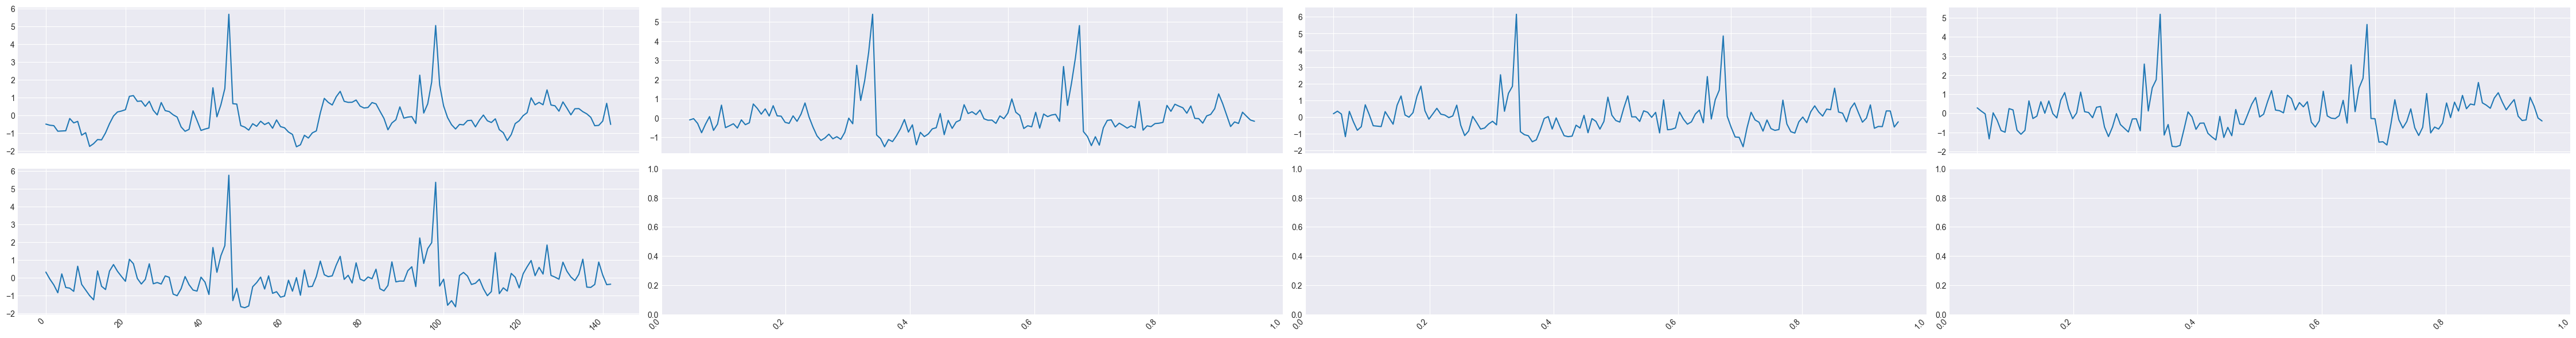

==========Cluster number: 1==========


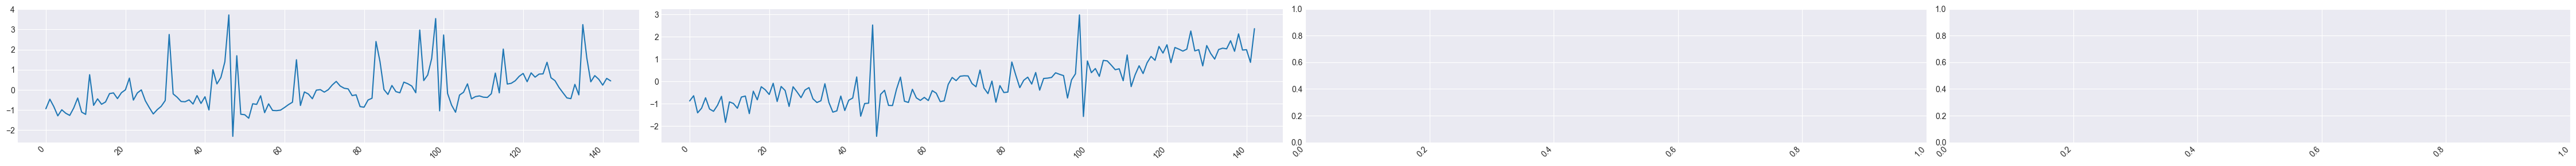

==========Cluster number: 2==========


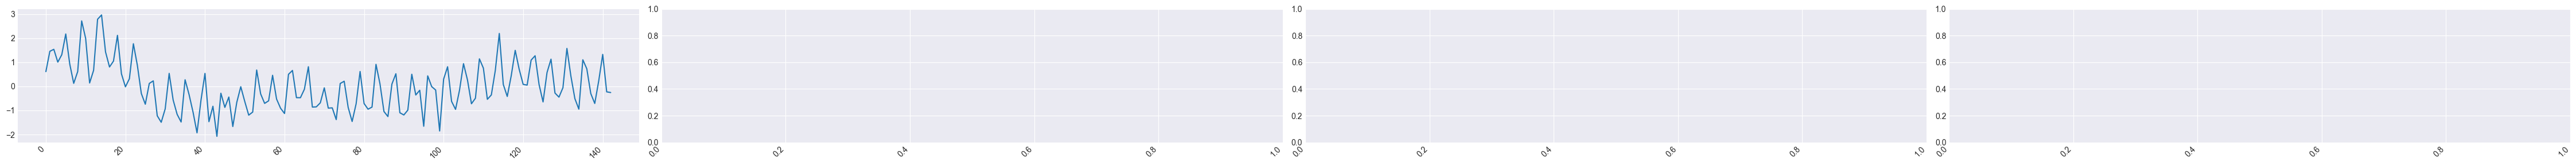

==========Cluster number: 3==========


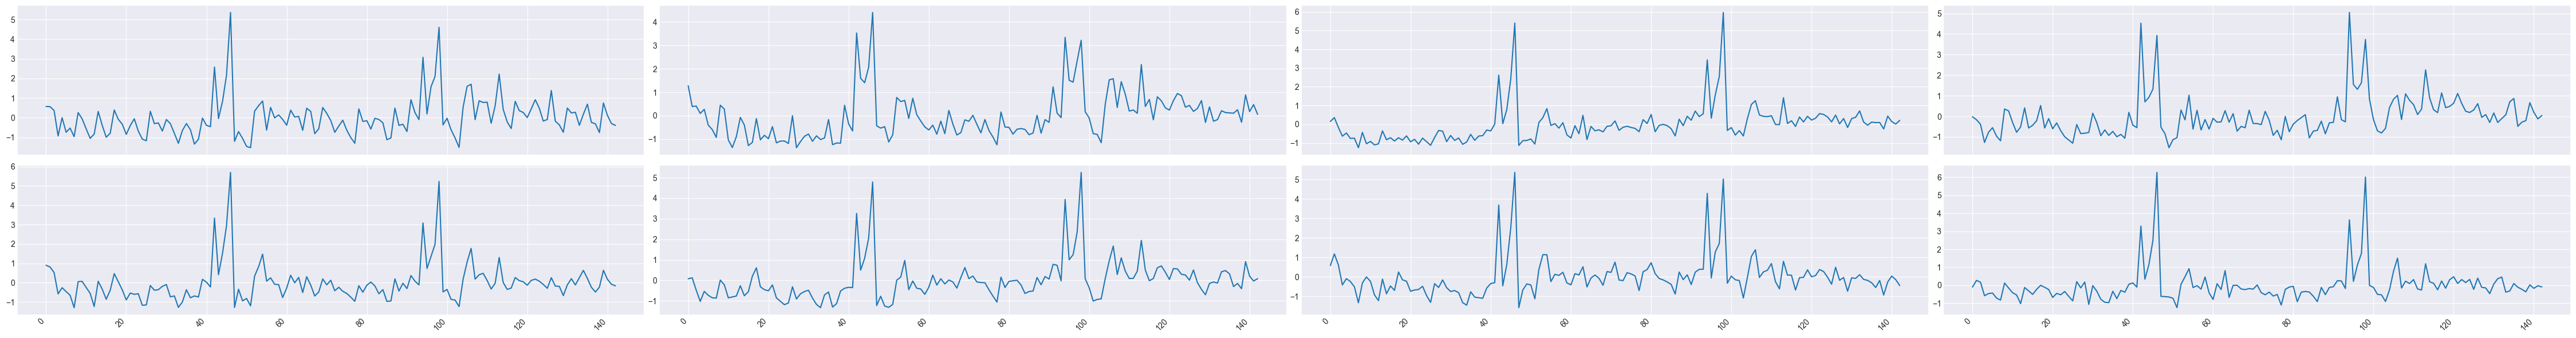

==========Cluster number: 4==========


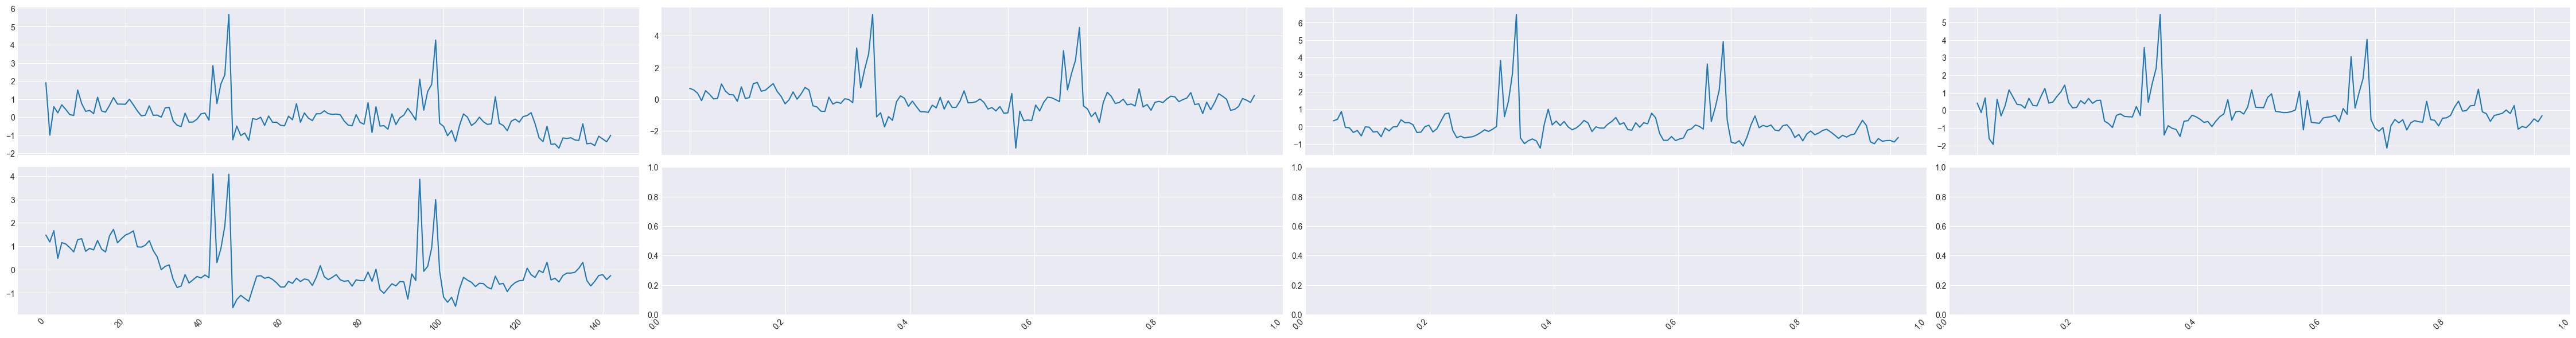

==========Cluster number: 5==========


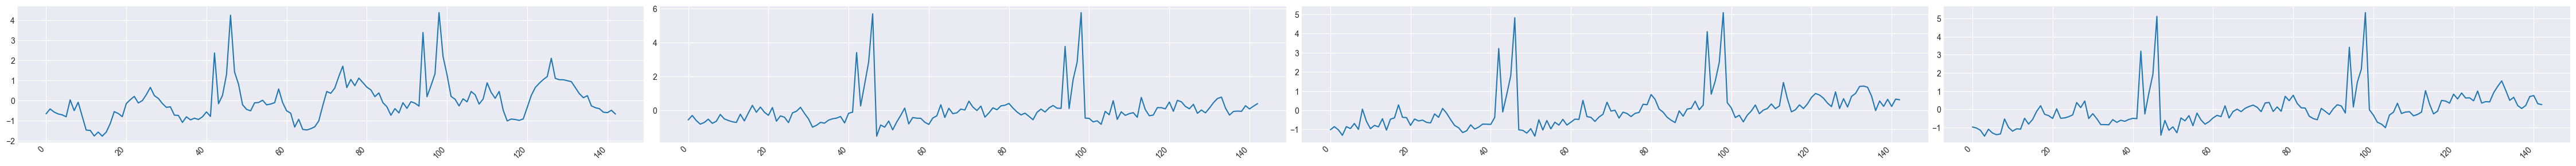

==========Cluster number: 6==========


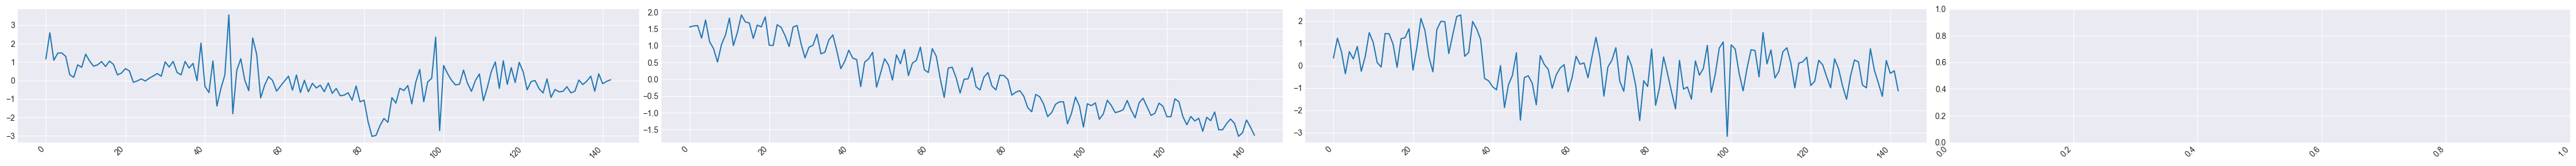

==========Cluster number: 7==========


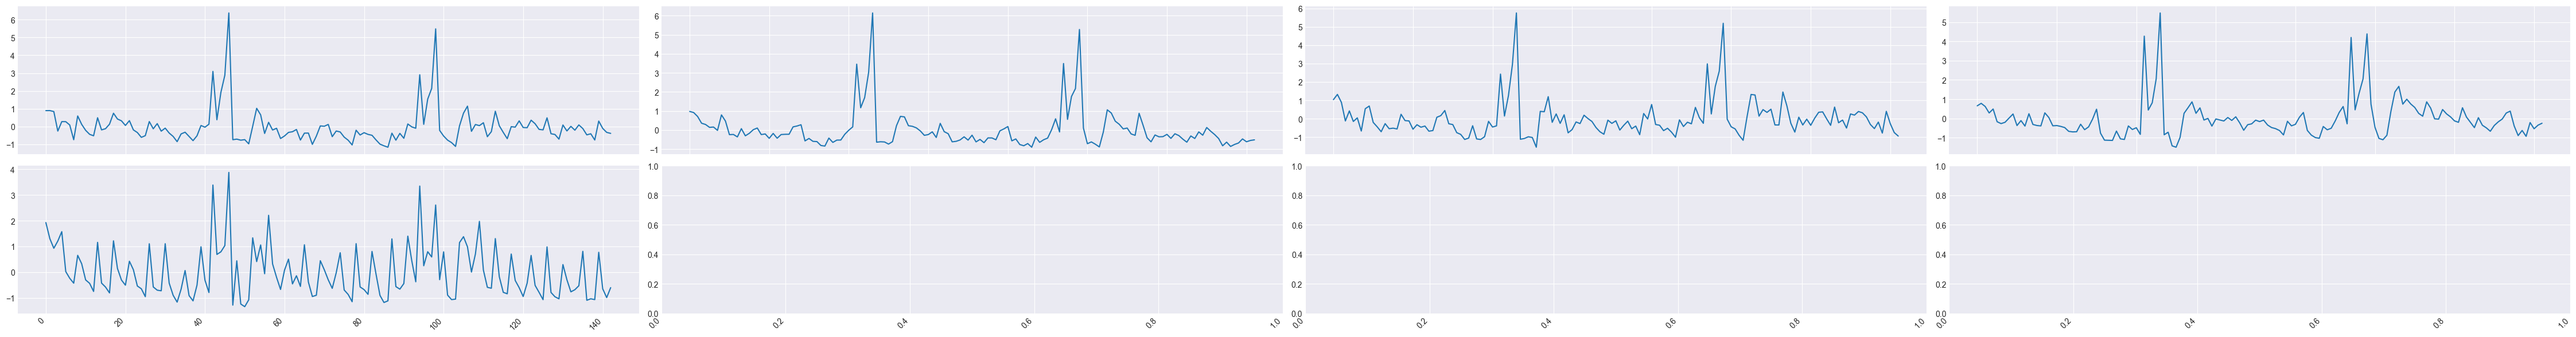

==========Cluster number: 8==========


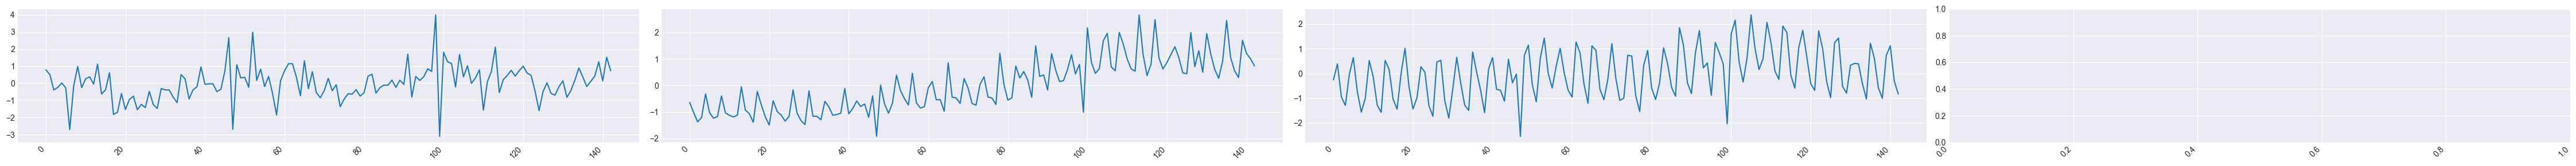

==========Cluster number: 9==========


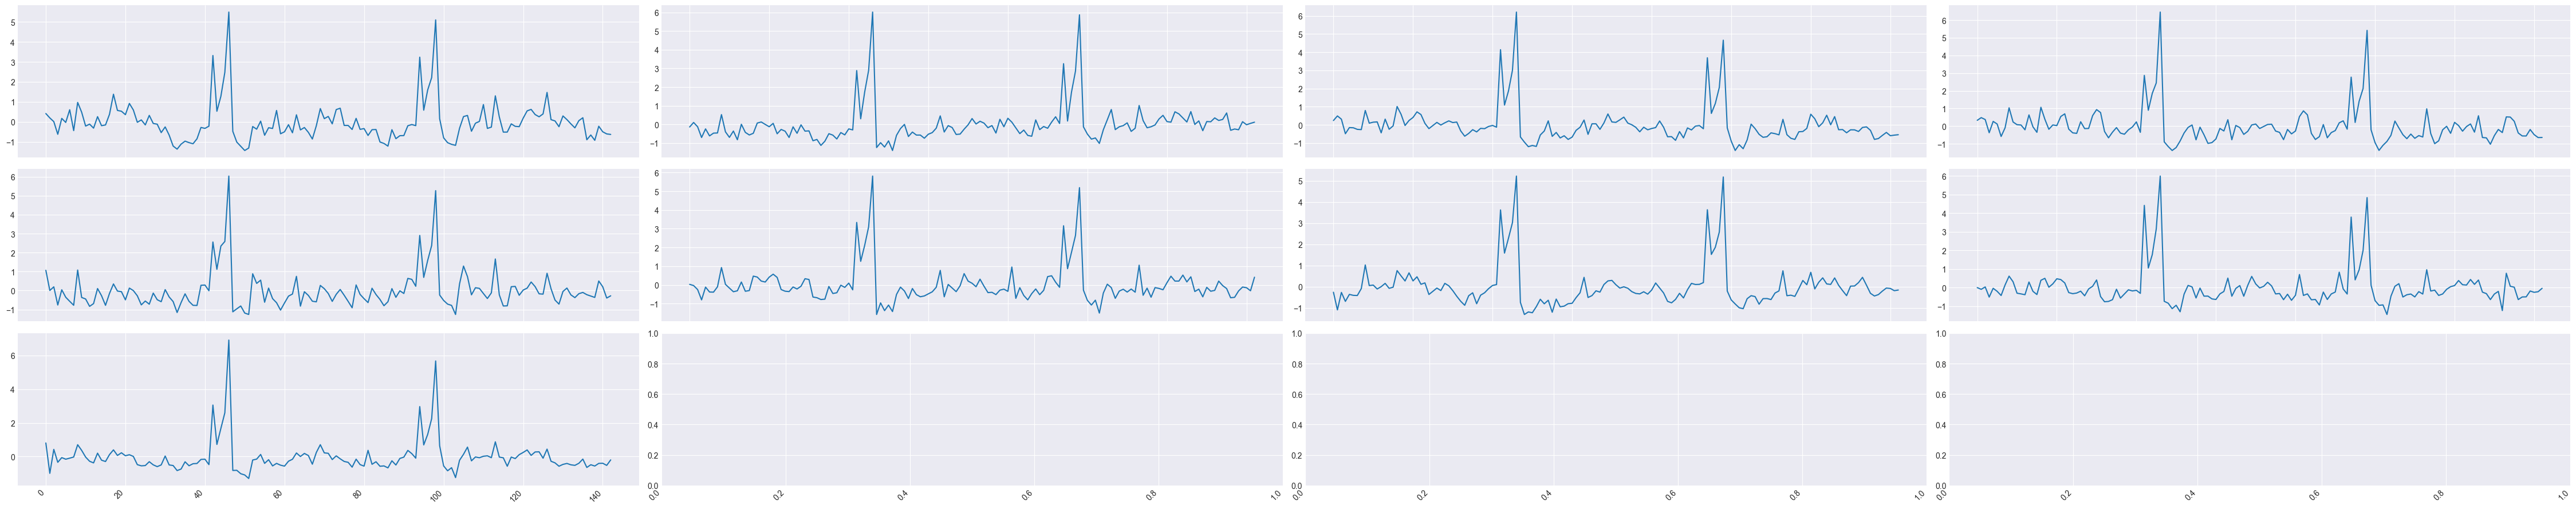

In [40]:
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])